# Deep learning project: Colorizing black and white images

## 0. Introduction
This notebook contains the code and results for the project done by Eric Johansson and Per Ljung in the course Deep machine learning (SSY340/DAT968). The main objective is to take black and white images as input and colorize them using <font color='red'>whatever we end up using</font>. <font color='green'>Further explore possibility of sequences of images.</font>

## 1. Collecting and pre-processing of data
As dataset we first use the MIT Places image database. The goal of this section is to
<ol>
  <li>Download the data from MIT Places.</li>
  <li>Split the data into training, validation and testing datasets.</li>
  <li>Provide a function that can turn a colorful image into black and white format.</li>
</ol>
We begin by importing necessary modules for the project.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets

import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1.1 Download data from MIT Places
To begin with, we will use a subset of the dataset Places205 from <a href="http://places.csail.mit.edu">MIT Places</a>, which is an image dataset containing 2,448,873 images from 205 scene categories. Our subset contains 41,000 images. In ubuntu, this can be done immediately in the terminal by the command
```
wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz -P path/to/project
```
and extract it. The code below takes the images and divides them into training and validation data.

### 1.2 Split data into training and validation
The subset contains 41,000 images. We split it into a training set containing 40,000 images and a validation set with 1,000 images. 

In [ ]:
# Divide data into training (40,000 images) and validation (1,000 images)
os.makedirs('images/train/', exist_ok=True)
os.makedirs('images/val/', exist_ok=True)
for i, file in enumerate(os.listdir('testSetPlaces205_resize/testSet_resize')):
  if i < 1000:
    os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/val/' + file)
  else:
    os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/train/' + file)

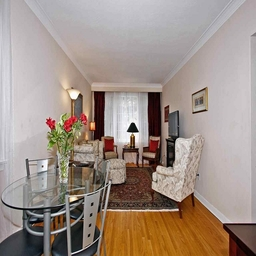

In [4]:
# Display an example image
from IPython.display import Image, display
display(Image(filename='images/val/05a9f2407d947da825a7f51661dd2c47.jpg'))

### 1.3 Construct network for colorization
We now define the network to train. <font color='red'>Description of what we use in the network like resnet, upsampling, etc.</font>

### 1.4 Visualization of LAB vs RGB images
To get a feel for LAB-images the below cell is dedicated for visualization of RGB and LAB images with their different channels. 
  
From wikipedia:    
The lightness value, $L$, also referred to as "Lstar," defines black at 0 and white at 100. The $a$ axis is relative to the green–red opponent colors, with negative values toward green and positive values toward red. The $b$ axis represents the blue–yellow opponents, with negative numbers toward blue and positive toward yellow.

  
<font color='red'>This cell is thought to be used in the initial states of the project, to get some intuition of the different formats and how to convert between them as well as how to produce figures from LAB-images since our network output will be in LAB format.</font>

Text(0.5, 1.0, 'LAB $b$ channel values (unnormalized)')

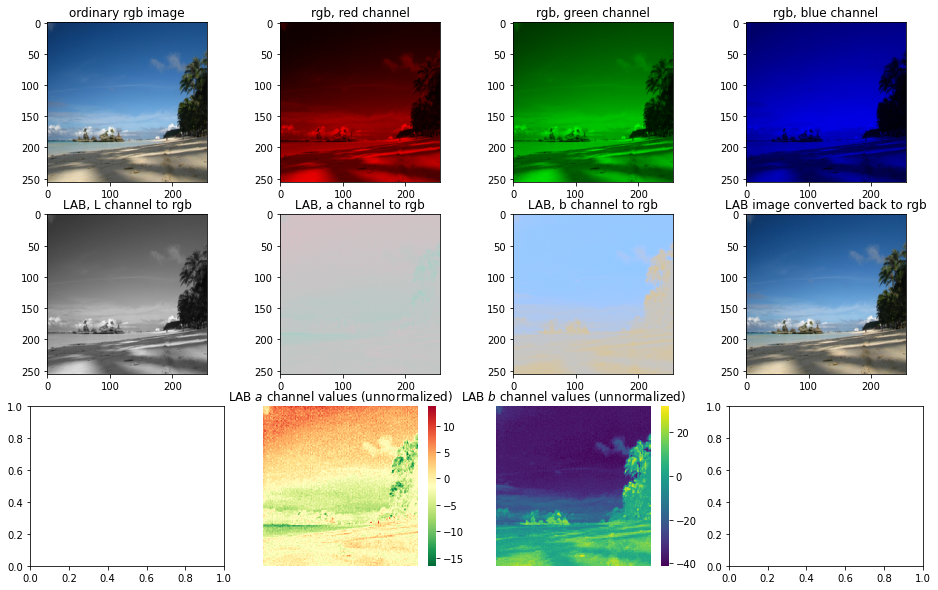

In [5]:
from skimage import io, color
import seaborn as sns

def get_rgb_and_lab_images(filename):
    """ Takes image filename as argument 
    
        Returns normalized rgb and lab images
    """   
    rgb = io.imread(filename)
    rgb_scaled = rgb/255    
    lab = color.rgb2lab(rgb)
    lab_scaled = (lab + [0, 128, 128]) / [100, 255, 255]   
    return rgb_scaled, lab_scaled

def get_rgb_channel_for_plotting(image, channel):
    """ Takes an image and the desired channel as arguments.
        channel: [0, 1, 2] = [red, green, blue]
        
        Returns an image with only the desired channel activated """
    rgb_channel = np.zeros(image.shape)
    rgb_channel[:,:,channel] += rgb[:,:,channel]
    return rgb_channel

def get_lab_channel_for_plotting(image, channel):
    """ Takes an image in lab format and the desired channel as arguments.
        channel: [0, 1, 2] = [Lightness, a, b]
        
        Expects the lab image to be scaled
        
        Returns an image with only the desired channel activated """
    lab_channel = np.zeros(image.shape)
    image = image*[100,255,255]-[0,128,128] # rescale
    lab_channel[:,:,channel] += image[:,:,channel]
    if channel != 0:
        lab_channel[:,:,0]+=80 # we need some light for the a and b channels to be visible
    lab_channel = color.lab2rgb(lab_channel)
    return lab_channel

def get_lab_for_plotting(image):
    """ Expects a scaled lab-image
    
        Returns the lab image converted to rgb """
    rescaled_lab = image*[100,255,255]-[0,128,128]
    rgb = color.lab2rgb(rescaled_lab)
    return rgb
    
filename = 'images/train/0a56c95e047247ac4df457d5663e03fe.jpg'    
    
fig, ax = plt.subplots(3,4, figsize = (16,10));
rgb, lab = get_rgb_and_lab_images(filename)

ax[0][0].imshow(rgb)
ax[0][0].set_title('ordinary rgb image')
ax[0][1].imshow(get_rgb_channel_for_plotting(rgb, 0))
ax[0][1].set_title('rgb, red channel')
ax[0][2].imshow(get_rgb_channel_for_plotting(rgb, 1))
ax[0][2].set_title('rgb, green channel')
ax[0][3].imshow(get_rgb_channel_for_plotting(rgb, 2))
ax[0][3].set_title('rgb, blue channel')
ax[1][0].imshow(get_lab_channel_for_plotting(lab, 0))
ax[1][0].set_title('LAB, L channel to rgb')
ax[1][1].imshow(get_lab_channel_for_plotting(lab, 1))
ax[1][1].set_title('LAB, a channel to rgb')
ax[1][2].imshow(get_lab_channel_for_plotting(lab, 2))
ax[1][2].set_title('LAB, b channel to rgb')
ax[1][3].imshow(get_lab_for_plotting(lab))
ax[1][3].set_title('LAB image converted back to rgb')

sns.heatmap(lab[:,:,1]*255-128, ax = ax[2][1], cmap="RdYlGn_r")
ax[2][1].set(xticks=[])
ax[2][1].set(yticks=[])
ax[2][1].set_title('LAB $a$ channel values (unnormalized)')
sns.heatmap(lab[:,:,2]*255-128, ax = ax[2][2], cmap="viridis")
ax[2][2].set(xticks=[])
ax[2][2].set(yticks=[])
ax[2][2].set_title('LAB $b$ channel values (unnormalized)')